In [1]:
%matplotlib inline

import gym
import matplotlib
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import itertools
import sys

if "../" not in sys.path:
  sys.path.append("../") 

from lib import plotting

matplotlib.style.use('ggplot')

In [2]:
env = gym.envs.make("MountainCar-v0")
env.observation_space, env.action_space

(Box(2,), Discrete(3))

In [3]:
import sklearn.pipeline
import sklearn.preprocessing
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_approximation import RBFSampler

# Feature Preprocessing: Normalize to zero mean and unit variance
# We use a few samples from the observation space to do this
observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(observation_examples)

# Used to convert a state to a featurizes represenation.
# We use RBF kernels with different variances to cover different parts of the space
featurizer = sklearn.pipeline.FeatureUnion([
        ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
        ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
        ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
        ("rbf4", RBFSampler(gamma=0.5, n_components=100))
        ])
featurizer.fit(scaler.transform(observation_examples))

FeatureUnion(n_jobs=None,
             transformer_list=[('rbf1',
                                RBFSampler(gamma=5.0, n_components=100,
                                           random_state=None)),
                               ('rbf2',
                                RBFSampler(gamma=2.0, n_components=100,
                                           random_state=None)),
                               ('rbf3',
                                RBFSampler(gamma=1.0, n_components=100,
                                           random_state=None)),
                               ('rbf4',
                                RBFSampler(gamma=0.5, n_components=100,
                                           random_state=None))],
             transformer_weights=None, verbose=False)

In [4]:
class LinReg(nn.Module):
    def __init__(self):
        super(LinReg, self).__init__()
        self.linear = nn.Linear(400, 1, bias=True)
        
        self.loss = torch.nn.MSELoss()
        self.optimizer = optim.SGD(self.parameters(), lr=0.001, momentum=0.9)
        
    def forward(self, X):
        X = self.linear(X)
        return X
    
    def update(self, state, target):
        pred = self.forward(state)
        assert(pred < 100000)
        loss = self.loss(pred, target.reshape(pred.shape))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
    
class Estimator:
    def __init__(self, env):        
        self.models = [LinReg() for a in range(env.action_space.n)]
                        
    def predict(self, state, action=None):
        features = self.featurize(state)
        if action:
            return self.models[action].forward(features)
        else:
            return torch.tensor([model.forward(features) for model in self.models])
        
    def featurize(self, state):
        scaled = scaler.transform([state])
        featurized = featurizer.transform(scaled)
        return torch.from_numpy(featurized[0]).float()
        
    def update(self, state, action, target):
        features = self.featurize(state)
        self.models[action].update(features, target)

In [5]:
def make_epsilon_greedy_policy(estimator, epsilon, nA):
    def policy_fn(state):
        A = torch.ones(nA) * epsilon / nA
        q_values = estimator.predict(state)
        best_action = torch.argmax(q_values)
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [6]:
def q_learning(env, estimator, num_episodes, discount_factor=1.0, epsilon=0.1, epsilon_decay=1.0):

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))  
    
    for i_episode in range(num_episodes):
        
        # The policy we're following
        policy = make_epsilon_greedy_policy(
            estimator, epsilon * (epsilon_decay ** i_episode), env.action_space.n
        )
        
        # Print out which episode we're on, useful for debugging.
        # Also print reward for last episode
        last_reward = stats.episode_rewards[i_episode - 1]
        sys.stdout.flush()
        
        # Reset the environment and pick the first action
        state = env.reset()
        
        # One step in the environment
        for t in itertools.count():
                        
            # Choose an action to take
            action_probs = policy(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            
            # Take a step
            next_state, reward, done, _ = env.step(action)
    
            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # TD Update
            q_values_next = estimator.predict(next_state)
            
            # Q-Value TD Target
            td_target = reward + discount_factor * torch.max(q_values_next)
            
            # Update the function approximator using our target
            estimator.update(state, action, td_target)
            
            print("\rStep {} @ Episode {}/{} ({})".format(t, i_episode + 1, num_episodes, last_reward), end="")
                
            if done:
                break
                
            state = next_state
            
    return stats

In [7]:
estimator = Estimator(env)

In [8]:
stats = q_learning(env, estimator, 300)

Step 174 @ Episode 300/300 (-135.0)

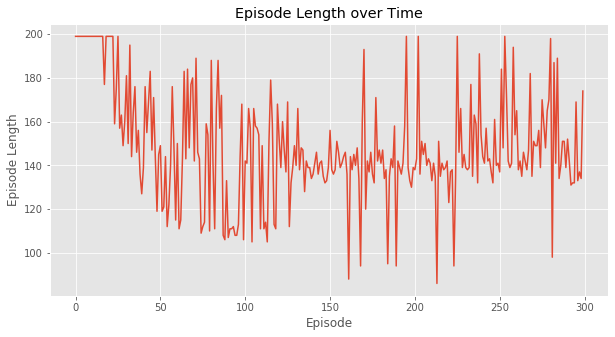

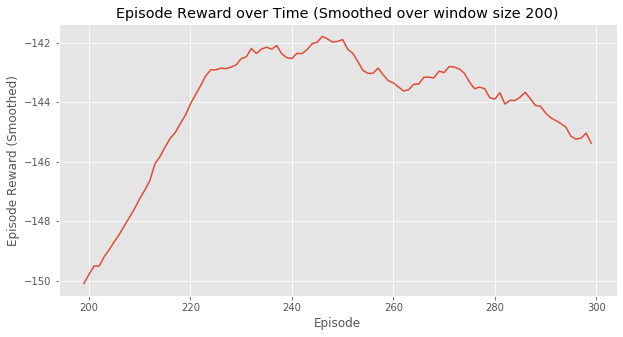

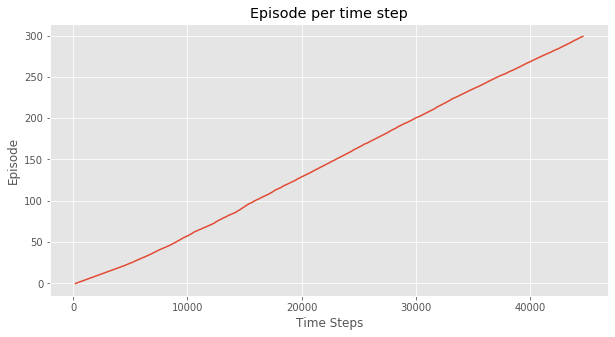

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [9]:
plotting.plot_episode_stats(stats, smoothing_window=200)